In [34]:
%pip install numpy pandas matplotlib scikit-learn wordcloud nltk -q

Note: you may need to restart the kernel to use updated packages.


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
# loading the dataset to a pandas dataframe
df = pd.read_csv('./src/movies.csv')

In [23]:
df.shape

(4803, 24)

In [40]:
# check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1432 entries, 0 to 1431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   genres    1432 non-null   object
 1   keywords  1432 non-null   object
 2   overview  1432 non-null   object
 3   title     1432 non-null   object
dtypes: object(4)
memory usage: 44.9+ KB


In [26]:
df = df.dropna().reset_index(drop=True)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1432 entries, 0 to 1431
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 1432 non-null   int64  
 1   budget                1432 non-null   int64  
 2   genres                1432 non-null   object 
 3   homepage              1432 non-null   object 
 4   id                    1432 non-null   int64  
 5   keywords              1432 non-null   object 
 6   original_language     1432 non-null   object 
 7   original_title        1432 non-null   object 
 8   overview              1432 non-null   object 
 9   popularity            1432 non-null   float64
 10  production_companies  1432 non-null   object 
 11  production_countries  1432 non-null   object 
 12  release_date          1432 non-null   object 
 13  revenue               1432 non-null   int64  
 14  runtime               1432 non-null   float64
 15  spoken_languages     

In [36]:
# filter the required columns for recommendation
required_columns = ["genres", "keywords", "overview", "title"]
df = df[required_columns]

In [38]:
df.head()

,genres,keywords,overview,title
0,Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,"In the 22nd century, a paraplegic Marine is di...",Avatar
1,Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,"Captain Barbossa, long believed to be dead, ha...",Pirates of the Caribbean: At World's End
2,Action Adventure Crime,spy based on novel secret agent sequel mi6,A cryptic message from Bond’s past sends him o...,Spectre
3,Action Crime Drama Thriller,dc comics crime fighter terrorist secret ident...,Following the death of District Attorney Harve...,The Dark Knight Rises
4,Action Adventure Science Fiction,based on novel mars medallion space travel pri...,"John Carter is a war-weary, former military ca...",John Carter


In [46]:
df['combined'] = df['genres'] + ' ' + df['keywords'] + ' ' + df['overview']


In [47]:
data = df[['title', 'combined']]

In [48]:
data.head()

,title,combined
0,Avatar,Action Adventure Fantasy Science Fiction cultu...
1,Pirates of the Caribbean: At World's End,Adventure Fantasy Action ocean drug abuse exot...
2,Spectre,Action Adventure Crime spy based on novel secr...
3,The Dark Knight Rises,Action Crime Drama Thriller dc comics crime fi...
4,John Carter,Action Adventure Science Fiction based on nove...


In [49]:
# Word Cloud for movie content
combined_text = " ".join(df['combined'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

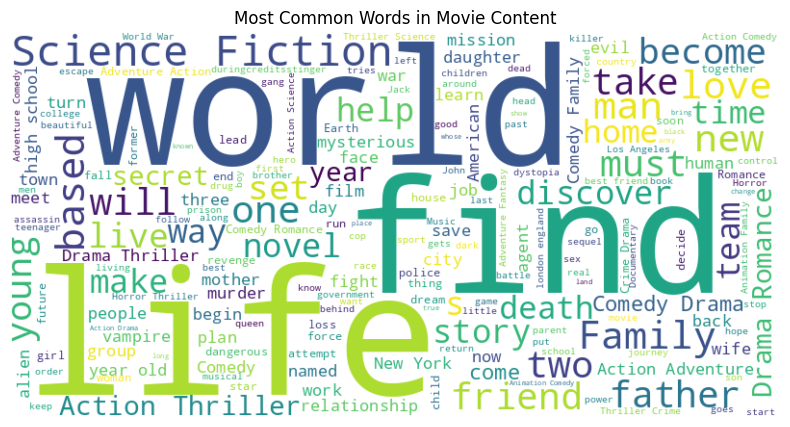

In [60]:
# WordCloud to visulize the most common words in the movie content
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Movie Content")
plt.show()

In [68]:
# download nltk data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/zisan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /home/zisan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /home/zisan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [69]:
stop_words = set(stopwords.words('english'))

In [70]:
def preprocess_text(text):
    # Remove special characters and digits
    text = re.sub(r"^a-zA-Z\s]", "", text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [71]:
# Apply preprocessing to the movie content
data['cleaned_text'] = df['combined'].apply(preprocess_text)

/tmp/ipykernel_120220/802455668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cleaned_text'] = df['combined'].apply(preprocess_text)


In [72]:
data.head()

,title,combined,cleaned_text
0,Avatar,Action Adventure Fantasy Science Fiction cultu...,action adventure fantasy science fiction cultu...
1,Pirates of the Caribbean: At World's End,Adventure Fantasy Action ocean drug abuse exot...,adventure fantasy action ocean drug abuse exot...
2,Spectre,Action Adventure Crime spy based on novel secr...,action adventure crime spy based novel secret ...
3,The Dark Knight Rises,Action Crime Drama Thriller dc comics crime fi...,action crime drama thriller dc comics crime fi...
4,John Carter,Action Adventure Science Fiction based on nove...,action adventure science fiction based novel m...


In [74]:
# Vectorization with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(data['cleaned_text'])

In [75]:


# Compute Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [77]:
print(cosine_sim[1])

[0.02688895 1.         0.03013905 ... 0.01874611 0.03805412 0.        ]


In [82]:
# Recommendation Function (content-based movie recommender)
def recommend_movies(movie_name, cosine_sim=cosine_sim, df=data, top_n=5):
    # Find the index of the movie
    idx = df[df['title'].str.lower() == movie_name.lower()].index
    if len(idx) == 0:
        return "Movie not found in the dataset!"
    idx = idx[0]

    # Get similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]

    # Get movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return top n similar movies
    return df[['title']].iloc[movie_indices]

In [78]:
data["title"]

0                                         Avatar
1       Pirates of the Caribbean: At World's End
2                                        Spectre
3                          The Dark Knight Rises
4                                    John Carter
                          ...                   
1427                                Down Terrace
1428                                      Clerks
1429                                   Dry Spell
1430                                 Tin Can Man
1431                                      Primer
Name: title, Length: 1432, dtype: object

In [79]:
# row_index = df[df['title'] == "Avengers: Age of Ultron"].index
row_index = df[df['title'] == "Batman v Superman: Dawn of Justice"].index
print(row_index)

Index([9], dtype='int64')


In [80]:
movie_name = data["title"][9]
print(movie_name)

Batman v Superman: Dawn of Justice


In [84]:
# Example Recommendation
print(f"Recommendations for the Movie {movie_name}")
recommendations = recommend_movies(movie_name)
print(recommendations)

Recommendations for the Movie Batman v Superman: Dawn of Justice
                    title
13           Man of Steel
58          Suicide Squad
3   The Dark Knight Rises
54        The Dark Knight
94          Batman Begins
